In [2]:
import sys
sys.path.append("../")


from scipy.sparse.csgraph import reverse_cuthill_mckee
from sklearn.metrics import pairwise_distances, pairwise
from scipy.sparse import csr_matrix
import matplotlib.gridspec as gridspec

import os
import math
import time
import numpy as np
import pandas as pd
from collections import Counter
import random

import torch
import torch_geometric
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [5]:
sstday_train=np.load("../../../Downloads/sstday_train.npy")
sstday_test=np.load("../../../Downloads/sstday_valid.npy")

data_sst = np.concatenate((sstday_train,sstday_test))
data_sst.shape

(2337, 70, 150)

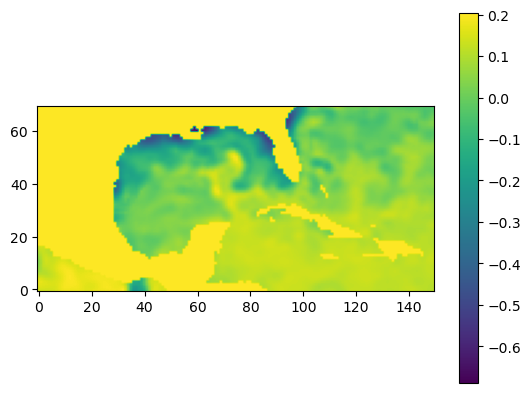

In [36]:
np.set_printoptions(threshold=sys.maxsize)
plt.imshow(data_sst[170],origin='lower')
plt.colorbar()

In [37]:
data_sst[0,20:50,0:20]

array([[0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238],
       [0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238],
       [0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238],
       [0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0.20286238, 0.20286238,
        0.20286238, 0.20286238, 0.20286238, 0

In [6]:
np.nanmin(data_sst)

-1.0

In [7]:
np.max(data_sst)

1.0

In [8]:
np.argmax(data_sst,axis=0)

array([[ 742,  742,  741, ..., 1128, 1128, 1128],
       [ 741,  741,  741, ..., 1129, 1127, 1137],
       [ 741,  741,  741, ..., 1129, 2263, 1137],
       ...,
       [   0,    0,    0, ..., 2202, 2202, 2202],
       [   0,    0,    0, ..., 2202, 2202, 2202],
       [   0,    0,    0, ..., 2202, 2202, 2202]])

/tmp/ipykernel_2348239/257209988.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


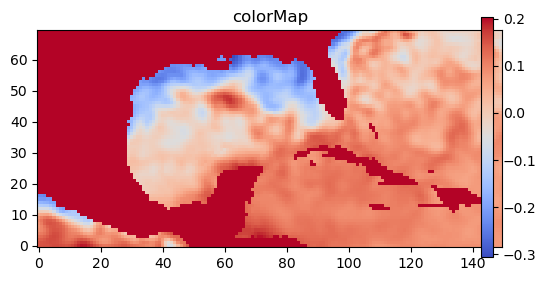

In [9]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(data_sst[210],origin='lower',cmap='coolwarm')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

In [177]:
#CHANGE BELOW DEPENDING ON FOLDER

In [38]:
seed = 0

In [39]:
import scipy.io
mat = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))

In [40]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pred', 'truth', 'init'])

In [41]:
t,m,n = mat['pred'].shape
mat['pred'].shape

(180, 70, 150)

In [42]:
nanflag = np.full((m, n), True)

/tmp/ipykernel_2348239/1671655055.py:16: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


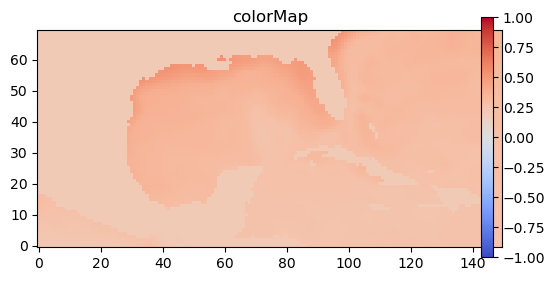

In [43]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
data = mat['pred'][150]
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

/tmp/ipykernel_2348239/2213407248.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


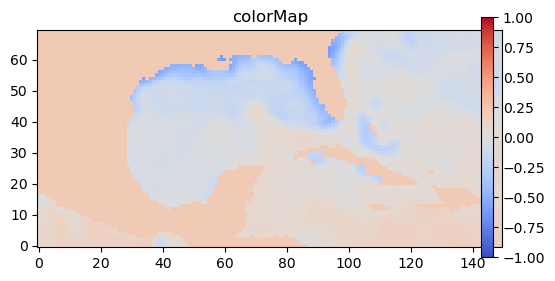

In [44]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')

data = mat['truth'][150]
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

/tmp/ipykernel_2348239/3847553450.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fraction=0.046, pad=0.04)


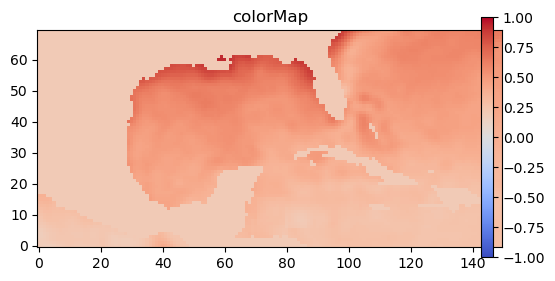

In [45]:
fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')

data = mat['init']
data[~nanflag] = np.nan

plt.imshow(data,origin='lower',cmap='coolwarm',vmin=-1, vmax=1)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

0.16702199
0.93433094
0.1904123
0.74386024
0.15984315
0.2139783
-0.5185978
0.78202313
-0.92478496
0.95581555
-0.92478496
0.95581555


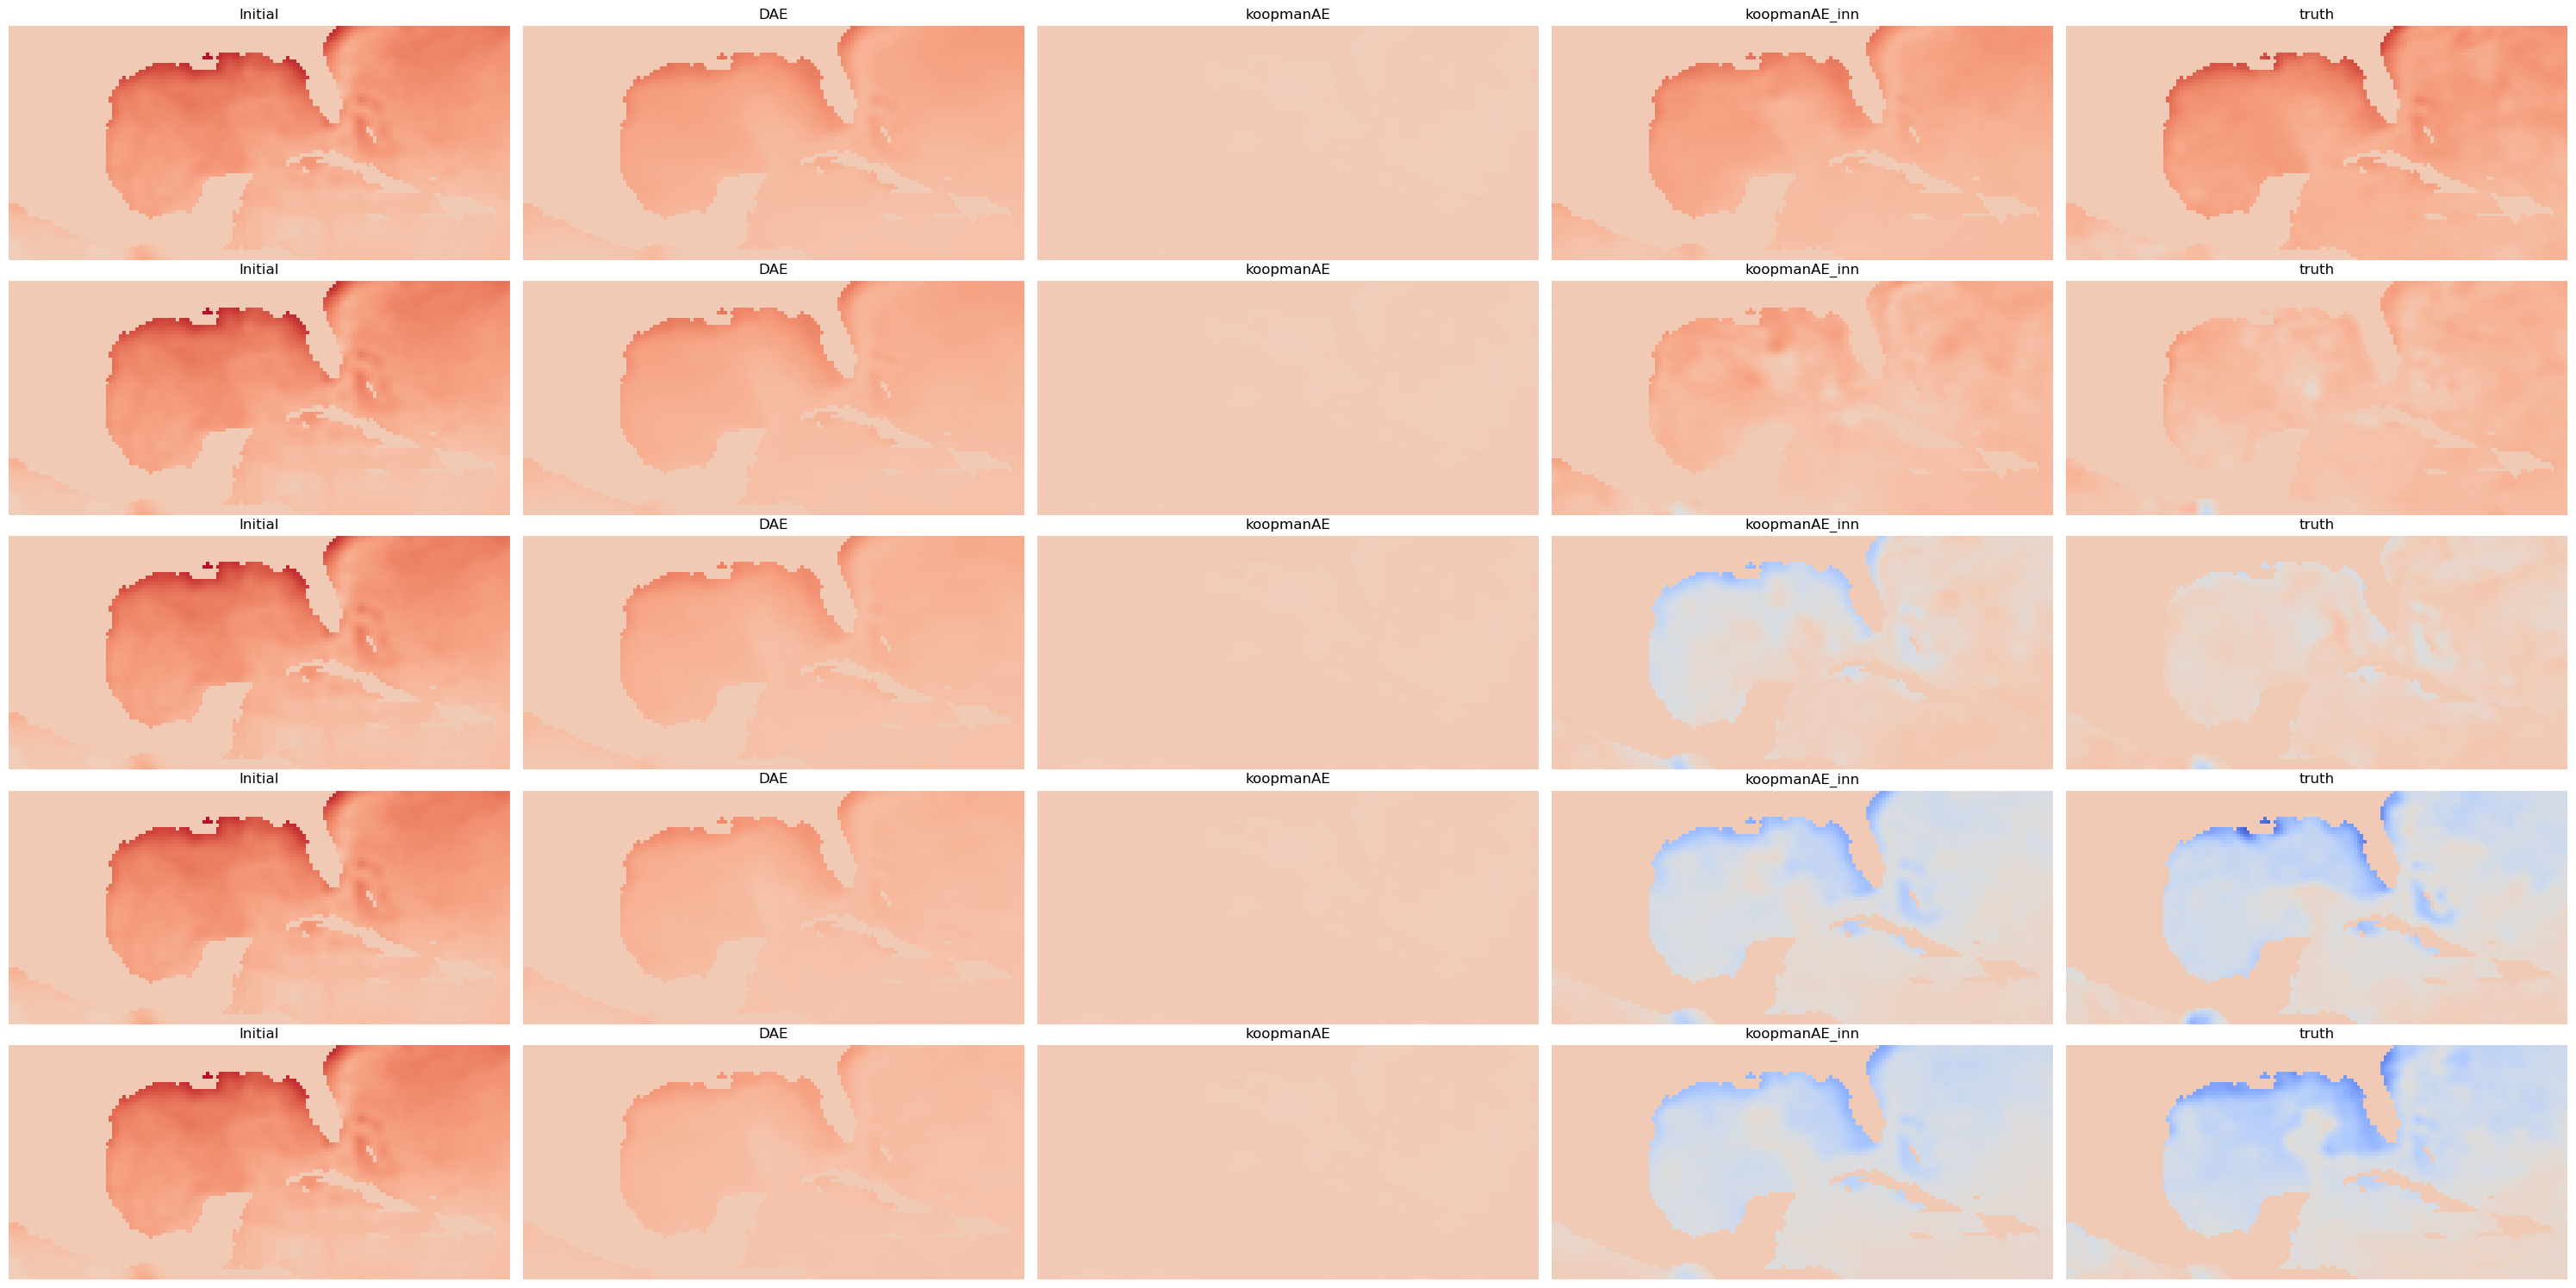

In [49]:
init = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['init']
init[~nanflag] = np.nan

print(np.nanmin(init))
print(np.nanmax(init))

DAE = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
DAE[:,~nanflag] = np.nan

print(np.nanmin(DAE))
print(np.nanmax(DAE))

koopmanAE = scipy.io.loadmat('results/results_det_back_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE[:,~nanflag] = np.nan

print(np.nanmin(koopmanAE))
print(np.nanmax(koopmanAE))

koopmanAE_INN = scipy.io.loadmat('results/results_det_back_inn_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE_INN[:,~nanflag] = np.nan

print(np.nanmin(koopmanAE_INN))
print(np.nanmax(koopmanAE_INN))


truth = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['truth']
truth[:,~nanflag] = np.nan

print(np.nanmin(truth))
print(np.nanmax(truth))

vmax= max( np.nanmax(init),np.nanmax(DAE),np.nanmax(koopmanAE),np.nanmax(koopmanAE_INN),np.nanmax(truth))
vmin= min( np.nanmin(init),np.nanmin(DAE),np.nanmin(koopmanAE),np.nanmin(koopmanAE_INN),np.nanmin(truth))


print(vmin)
print(vmax)





# create a figure with 5 x 5 subplots
fig, axes = plt.subplots(5, 5, figsize=(30, 15))


# get a 1-dimensional list of axis objects
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)

for i in range(int(num_subplots/5)):
    # generate random y values and plot this series
    ax = ax_list.pop()
    ax.imshow(init,origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("Initial")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(DAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("DAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("koopmanAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE_INN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("koopmanAE_inn")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(truth[35*(i+1)],origin='lower',cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_title("truth")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
# display the figure


fig.tight_layout()
plt.show()

DAE 0.111353
koopmanAE 0.11091798
koopmanAE_INN 0.031681966
truth 0.0


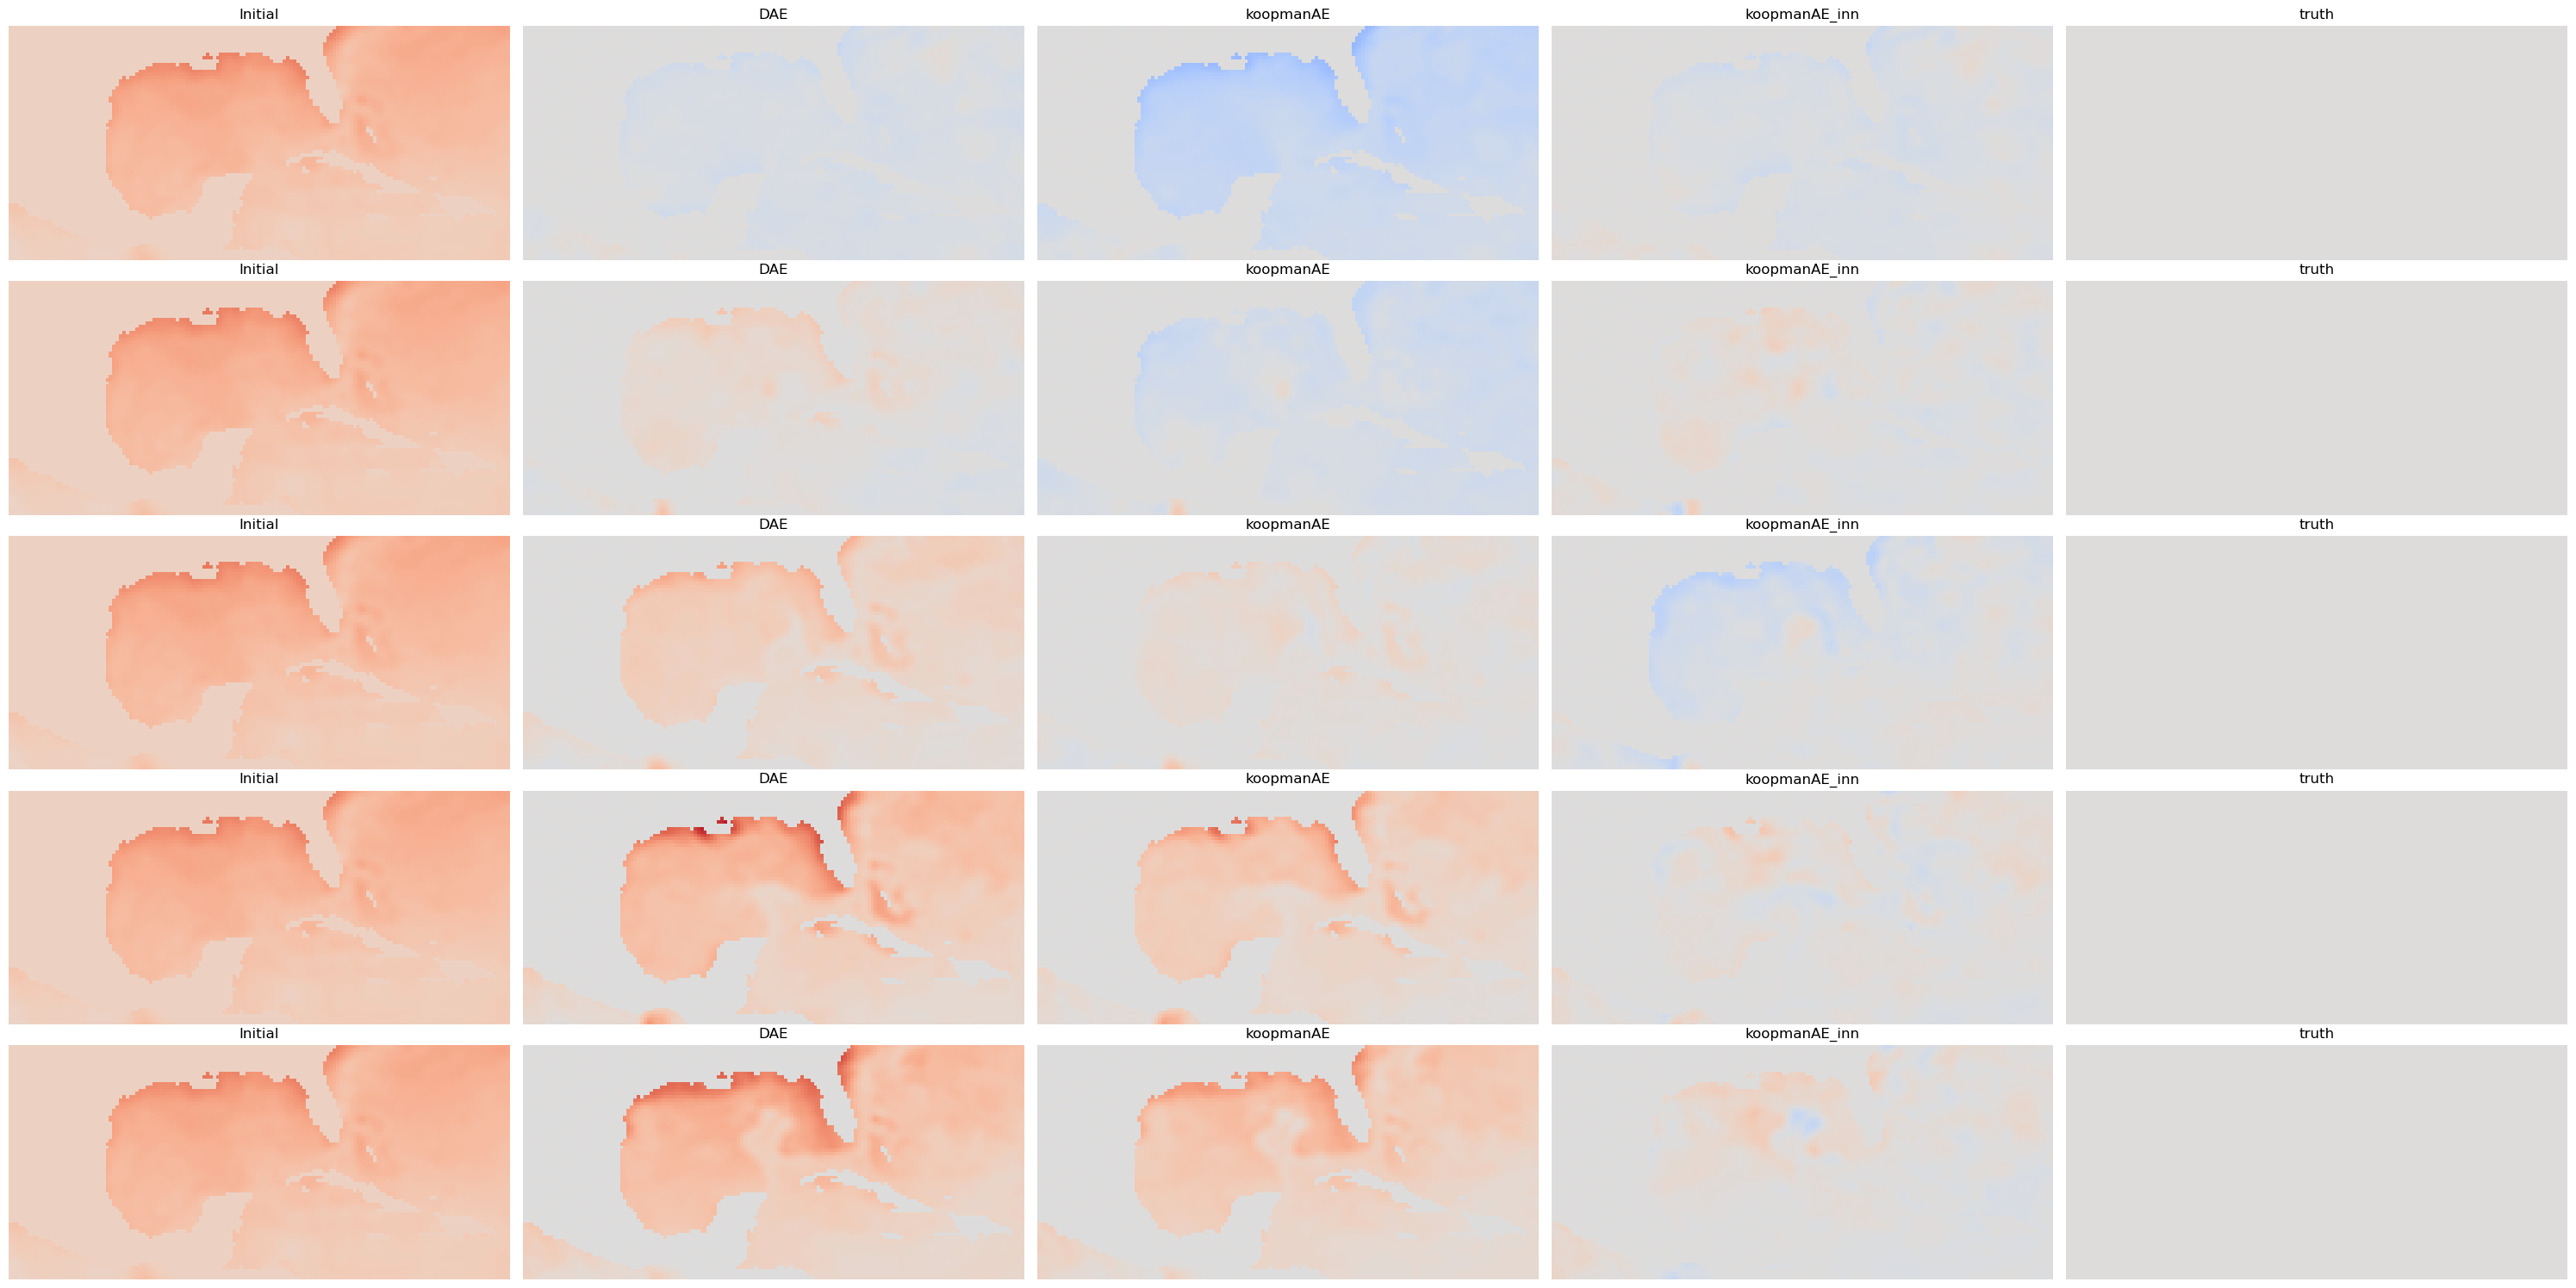

In [48]:
init = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['init']
init[~nanflag] = np.nan

# print(np.nanmin(init))
# print(np.nanmax(init))


truth = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['truth']
truth[:,~nanflag] = np.nan




# print(np.nanmin(truth))
# print(np.nanmax(truth))



DAE = scipy.io.loadmat('results/results_det_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
DAE[:,~nanflag] = np.nan
DAE = DAE - truth 
print("DAE",np.nanmean(np.abs(DAE)))

# print(np.nanmin(DAE))
# print(np.nanmax(DAE))

koopmanAE = scipy.io.loadmat('results/results_det_back_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE[:,~nanflag] = np.nan
koopmanAE = koopmanAE - truth 
print("koopmanAE",np.nanmean(np.abs(koopmanAE)))


# print(np.nanmin(koopmanAE))
# print(np.nanmax(koopmanAE))

koopmanAE_INN = scipy.io.loadmat('results/results_det_back_inn_sst_omri_alpha6_bottle_10_seed_{}/snapshots_pred.mat'.format(seed))['pred']
koopmanAE_INN[:,~nanflag] = np.nan
koopmanAE_INN = koopmanAE_INN - truth 
print("koopmanAE_INN",np.nanmean(np.abs(koopmanAE_INN)))



# print(np.nanmin(koopmanAE_INN))
# print(np.nanmax(koopmanAE_INN))


# print(np.nanmin(X_prev))
# print(np.nanmax(X_prev))



vmax= max( np.nanmax(init),np.nanmax(DAE),np.nanmax(koopmanAE),np.nanmax(koopmanAE_INN),np.nanmax(truth))
vmin= min( np.nanmin(init),np.nanmin(DAE),np.nanmin(koopmanAE),np.nanmin(koopmanAE_INN),np.nanmin(truth))

vabs = max(abs(vmax),abs(vmin))


# print(vmin)
# print(vmax)


truth = truth -truth
print("truth",np.nanmean(np.abs(truth)))



# create a figure with 5 x 5 subplots
fig, axes = plt.subplots(5, 5, figsize=(30, 15))


# get a 1-dimensional list of axis objects
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)

for i in range(int(num_subplots/5)):
    # generate random y values and plot this series
    ax = ax_list.pop()
    ax.imshow(init,origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("Initial")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(DAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("DAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("koopmanAE")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(koopmanAE_INN[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("koopmanAE_inn")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    
    ax = ax_list.pop()
    ax.imshow(truth[35*(i+1)],origin='lower',cmap='coolwarm',vmin=-vabs, vmax=vabs)
    ax.set_title("truth")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')
    

    
# display the figure

fig.tight_layout()
plt.show()